# Example Codes for Using the Mean Shift Algorithms in ``SCONCE-SCMS``

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from mpl_toolkits.basemap import Basemap

from sconce.utils import cart2sph, sph2cart, GaussMixture, vMFMixtureSamp, vMFGaussMixture
from sconce.EucSCMS import KDE, MS
from sconce.DirSCMS import DirKDE, DirMS
from sconce.DirLinSCMS import DirLinKDE, DirLinMS

import ray
from sconce.EucSCMS_RayFunc import MS_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray
from sconce.DirLinSCMS_RayFunc import DirLinMS_Ray

## Example 1: Mode-seeking on a 2D Gaussian mixture density

In [2]:
# Set up the parameters for the Gaussian mixture model
mu = np.array([[1,1], [-1,-1]])
cov = np.zeros((2,2,2))
cov[:,:,0] = np.diag([1/4,1/4])
cov[:,:,1] = np.array([[1/2,1/4], [1/4,1/2]])
prob = [0.4, 0.6]

np.random.seed(123)  ## Set an arbitrary seed for reproducibility
Gau_data = GaussMixture(2000, mu=mu, cov=cov, prob=prob)

# Estimate the densities on query points
n_x = 100
n_y = 100
x = np.linspace(-3.5, 3.5, n_x)
y = np.linspace(-3.5, 3.5, n_y)
X, Y = np.meshgrid(x, y)
query_pts = np.concatenate((X.reshape(n_x*n_y, 1), Y.reshape(n_x*n_y, 1)), axis=1)
d_hat1 = KDE(query_pts, Gau_data, h=None)
Z1 = d_hat1.reshape(n_x, n_y)

The current bandwidth is 0.32893476047421333.



In [3]:
# Apply the standard MS algorithm to the Gaussian mixture dataset
MS_path = MS(Gau_data, Gau_data, h=None, eps=1e-9, max_iter=1000, wt=None)
EuModes = MS_path[:,:,MS_path.shape[2]-1]

The current bandwidth is 0.32893476047421333.

The MS algorithm converges in 179steps!


#### Parallel implementation of the standard/Euclidean mean shift algorithm

In [4]:
# MS
ray.init()
mesh_0 = Gau_data
dataset = Gau_data
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=0.3289, eps=1e-9, max_iter=5000))
EuMS_pts = ray.get(result_ids)
EuMS_pts = np.concatenate(EuMS_pts, axis=0)
ray.shutdown()

2022-07-19 06:23:41,940	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


The outputs from the standard and parallel implementations of the standard/Euclidean mean shift algorithm in ``sconce-scms`` are consistent under some precision levels.

In [5]:
print(all(LA.norm(EuModes - EuMS_pts, axis=1) < 1e-3))

True


In [6]:
a = LA.norm(EuModes - EuMS_pts, axis=1)
a[a>1e-3]

array([], dtype=float64)

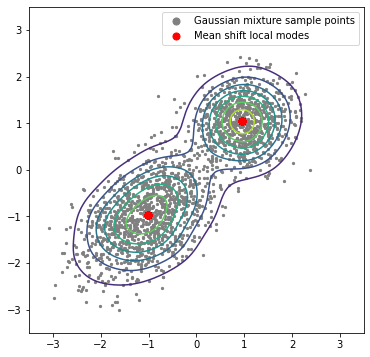

In [7]:
fig = plt.figure(figsize=(6,6))
X_m = EuModes[:,0]
Y_m = EuModes[:,1]
plt.contour(X, Y, Z1, cmap='viridis')
plt.scatter(Gau_data[:,0], Gau_data[:,1], color='grey', s=5, label='Gaussian mixture sample points')
plt.scatter(X_m, Y_m, s=40, color='red', label='Mean shift local modes')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()

## Example 2: Mode-seeking on a von Mises-Fisher (vMF) mixture density on $\mathbb{S}^2$

In [8]:
np.random.seed(123)   ## Set a seed only for reproducibility
## Generate a vMF random sample with three local modes
mode3 = np.array([[-120,-45], [0,60], [150,0]])   ## Local modes in degree
x3, y3, z3 = sph2cart(*mode3.T)
mu3 = np.concatenate((x3.reshape(3,1), y3.reshape(3,1), z3.reshape(3,1)), axis=1)

np.random.seed(123)  ## Set a seed only for reproducibility
kappa3 = [8.0, 8.0, 5.0]
prob3 = [0.3, 0.3, 0.4]
vMF_data3 = vMFMixtureSamp(2000, mu=mu3, kappa=kappa3, prob=prob3)
lon3, lat3, R = cart2sph(*vMF_data3.T)

# Set up the query points for computing the estimated densities
nrows, ncols = (100, 180)
lon, lat = np.meshgrid(np.linspace(-180, 180, ncols), np.linspace(-90, 90, nrows))
xg, yg, zg = sph2cart(lon, lat)
query_points = np.concatenate((xg.reshape(nrows*ncols, 1), 
                               yg.reshape(nrows*ncols, 1),
                               zg.reshape(nrows*ncols, 1)), axis=1)
d_hat3 = DirKDE(query_points, vMF_data3).reshape(nrows, ncols)

The current bandwidth is 0.3136780352409482.



In [9]:
## Perform directional mean shift algorithm on the generated random sample
DMS_path = DirMS(vMF_data3, vMF_data3, h=None, eps=1e-7, max_iter=1000)
Dmodes = DMS_path[:,:,DMS_path.shape[2]-1]

The current bandwidth is 0.3136780352409482.

The directional mean shift algorithm converges in 37 steps!


#### Parallel implementation of the directional mean shift algorithm

In [10]:
# DMS
ray.init()
mesh_0 = vMF_data3
dataset = vMF_data3
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=0.3137, eps=1e-9, max_iter=5000))
DMS_pts = ray.get(result_ids)
DMS_pts = np.concatenate(DMS_pts, axis=0)
ray.shutdown()

2022-07-19 06:24:14,398	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


The outputs from the standard and parallel implementations of the directional mean shift algorithm in ``sconce-scms`` are consistent under some precision levels.

In [11]:
print(all(np.arccos(np.diag(np.dot(Dmodes, DMS_pts.T))) < 1e-3))

True


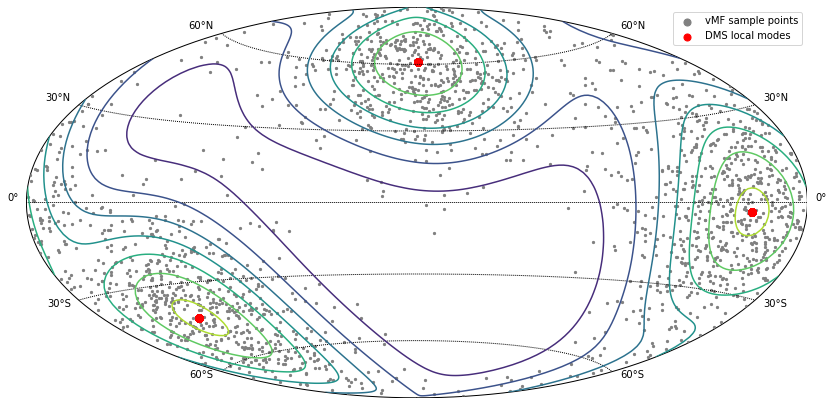

In [12]:
fig=plt.figure(figsize=(14,8))
lon_p, lat_p, R = cart2sph(*vMF_data3.T)
lon4, lat4, R = cart2sph(*Dmodes.T)
m2 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
             llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# draw lat/lon grid lines every 30 degrees.
m2.drawparallels(np.arange(-90, 90, 30), labels=[1,1,0,1])
x, y = m2(lon, lat)
x_p, y_p = m2(lon_p, lat_p)
x4, y4 = m2(lon4, lat4)
# contour data over the map.
cs = m2.contour(x, y, d_hat3)
cs = m2.scatter(x_p, y_p, color='grey', s=5, label='vMF sample points')
cs = m2.scatter(x4, y4, color='red', s=50, label='DMS local modes')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()

## Example 3: Mode-seeking on a cylinder ($\mathbb{S}^1\times \mathbb{R}$ data)

In [13]:
np.random.seed(123)  ## Set an arbitrary seed for reproducibility
prob1 = [2/5, 1/5, 2/5]   ## Mixture probabilities
mu_N1 = np.array([[0], [1], [2]])  ## Means of the Gaussian component
cov1 = np.array([1/4, 1, 1]).reshape(1,1,3)   ## Variances of the Gaussian components
mu_vMF1 = np.array([[1, 0], [0, 1], [-1, 0]])   ## Means of the vMF components
kappa1 = [3, 10, 3]   ## Concentration parameters of the vMF components
# Sample 1000 points from the vMF-Gaussian mixture model
vMF_Gau_data = vMFGaussMixture(1000, q=1, D=1, mu_vMF=mu_vMF1, kappa=kappa1, 
                             mu_N=mu_N1, cov=cov1, prob=prob1)
# Convert the vMF components of the simulated data to their angular coordinates
Angs = np.arctan2(vMF_Gau_data[:,1], vMF_Gau_data[:,0])
vMF_Gau_Ang = np.concatenate([Angs.reshape(-1,1), vMF_Gau_data[:,2].reshape(-1,1)], axis=1)

# Bandwidth selection
data = vMF_Gau_data
n = vMF_Gau_data.shape[0]
q = 1
D = 1
data_Dir = data[:,:(q+1)]
data_Lin = data[:,(q+1):(q+1+D)]

# Set up a set of mesh points and estimate the density values on it
nrows, ncols = (100, 100)
ang_qry = np.linspace(-np.pi-0.1, np.pi+0.1, nrows)
lin_qry = np.linspace(-2, 5.5, ncols)
ang_m1, lin_m1 = np.meshgrid(ang_qry, lin_qry)
X = np.cos(ang_m1.reshape(-1,1))
Y = np.sin(ang_m1.reshape(-1,1))
mesh1 = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), 
                        lin_m1.reshape(-1,1)], axis=1)
d_DirLin = DirLinKDE(mesh1, data=vMF_Gau_data, h=None, b=None, q=1, D=1).reshape(nrows, ncols)

The current bandwidth for directional component is 0.43657577503165496.

The current bandwidth for linear component is 0.3321889036080625.



In [14]:
# Mode-seeking on the denoised data with our proposed mean shift algorithm
DLMS_path = DirLinMS(vMF_Gau_data, vMF_Gau_data, h=None, b=None, q=1, D=1, eps=1e-7, max_iter=3000)
DLmodes = DLMS_path[:,:,DLMS_path.shape[2]-1]

The current bandwidth for directional component is 0.43657577503165496.

The current bandwidth for linear component is 0.3321889036080625.

The directional-linear MS algorithm converges in 155steps!


#### Parallel implementation of the directional-linear mean shift algorithm

In [15]:
# DirLinMS
ray.init()
mesh_0 = vMF_Gau_data
dataset = vMF_Gau_data
chunksize = 10
num_p = mesh_0.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(DirLinMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=0.4366, b=0.3322, 
                                          q=1, D=1, eps=1e-7, max_iter=5000))
DLMS_pts = ray.get(result_ids)
DLMS_pts = np.concatenate(DLMS_pts, axis=0)
ray.shutdown()

2022-07-19 06:24:33,789	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


The outputs from the standard and parallel implementations of the directional-linear mean shift algorithm in ``sconce-scms`` are consistent under some precision levels.

In [16]:
print(all(LA.norm(DLmodes - DLMS_pts, axis=1) < 1e-4))

True


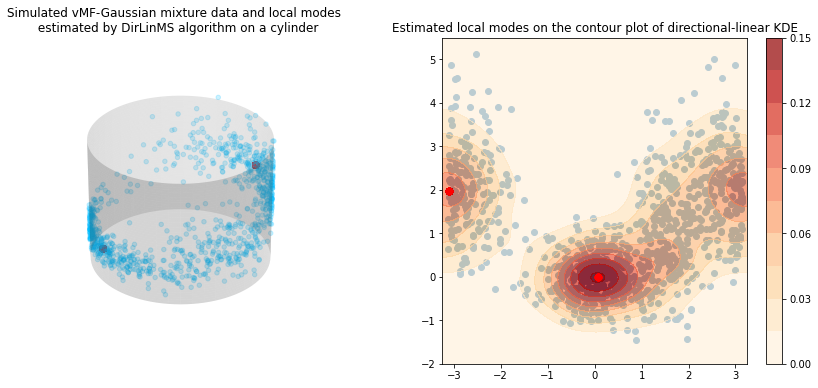

In [17]:
# Create a cylinder for the directional-linear space
theta = np.linspace(-np.pi, np.pi, 100)
z = np.linspace(-2, 5, 100)
th_m, Zc = np.meshgrid(theta, z)
Xc = np.cos(th_m)
Yc = np.sin(th_m)

fig = plt.figure(figsize=(15,6))
# Plot the simulated data points and local modes on the cylinder
Modes_angs = np.arctan2(DLmodes[:,1], DLmodes[:,0])
ax = fig.add_subplot(121, projection='3d')
ax.view_init(30, 60)
ax.plot_surface(Xc, Yc, Zc, alpha=0.2, color='grey')
ax.scatter(vMF_Gau_data[:,0], vMF_Gau_data[:,1], vMF_Gau_data[:,2], 
           alpha=0.2, color='deepskyblue')
ax.scatter(DLmodes[:,0], DLmodes[:,1], DLmodes[:,2], 
           color='red', s=40)
ax.axis('off')
plt.title('Simulated vMF-Gaussian mixture data and local modes \n estimated '\
          'by DirLinMS algorithm on a cylinder')

# Plot the local modes on the contour plot of the estimated density
plt.subplot(122)
plt.scatter(Angs, vMF_Gau_data[:,2], alpha=1)
plt.contourf(ang_m1, lin_m1, d_DirLin, 10, cmap='OrRd', alpha=0.7)
plt.colorbar()
plt.scatter(Modes_angs, DLmodes[:,2], color='red', s=40)
plt.title('Estimated local modes on the contour plot of directional-linear KDE')
plt.show()